In [36]:
import numpy as np
from scipy.special import erf, erfinv
import matplotlib.pyplot as plt
import pyregion
from tqdm import tqdm

In [24]:
from astropy.io import fits

# Open the FITS file
file_name = "continuum_subtracted.fits"  # Replace with your FITS file
with fits.open(file_name) as hdul:
    # Get the header from the primary HDU
    header = hdul[0].header

# Save the header to a text file
output_file = "cube_last_version.txt"
with open(output_file, 'w') as f:
    f.write(repr(header))

print(f"Header saved to {output_file}")

Header saved to cube_last_version.txt


Estimated noise level (σ): 1.26e-15 ergs/cm^2/s/Å
The flux upper limit for non-detection is: 3.77e-15 ergs/cm^2/s/Å
The flux upper limit for non-detection is: 5.38e-15 ergs/cm^2/s/Å
The flux upper limit for non-detection is: 6.34e-15 ergs/cm^2/s/Å


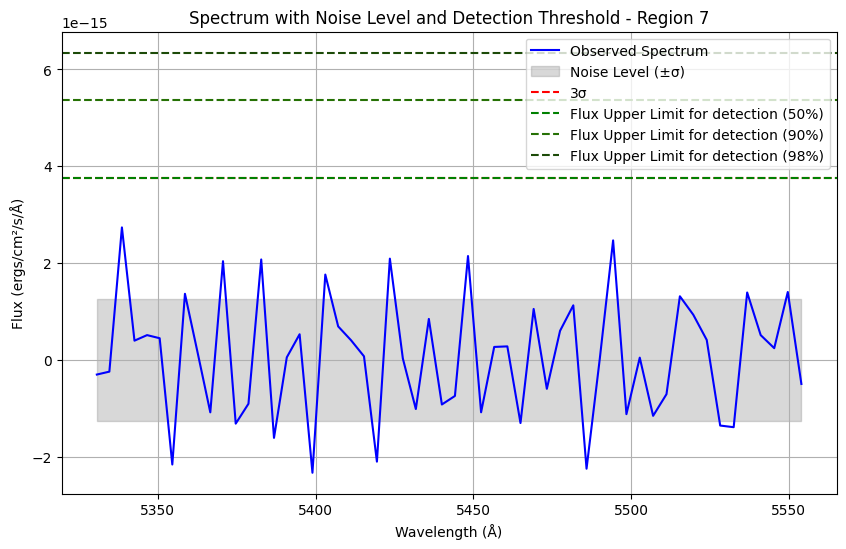

In [77]:
data = np.loadtxt("region_7_spec.txt", skiprows=1) # Load the data the spectrum
wavelengths = data[:, 0]
fluxes = data[:, 1]

# Calculate the noise level (σ)
def calculate_noise_level(spectrum):
    """Calculate the standard deviation of the noise in the spectrum."""
    return np.std(spectrum)

sigma = calculate_noise_level(fluxes)
print(f"Estimated noise level (σ): {sigma:.2e} ergs/cm^2/s/Å")

# Set the detection parameters
detection_threshold = 3  # 3σ detection threshold
desired_detection_probability = [0.50,0.9,.98]  # Desired detection probability (e.g., 98%)

# Calculate the flux upper limit for non-detection
 
def calculate_flux_upper_limit(sigma, detection_threshold, desired_detection_probability):
    """Calculate the flux upper limit for non-detection."""
    inverse_erf_value = erfinv(2 * desired_detection_probability - 1)
    flux_upper_limit = detection_threshold * sigma + np.sqrt(2) * sigma * inverse_erf_value
    return flux_upper_limit
flux_upper_lim = []
for i in desired_detection_probability:
    flux_upper_limit = calculate_flux_upper_limit(sigma, detection_threshold, i)
    flux_upper_lim.append(flux_upper_limit)
    print(f"The flux upper limit for non-detection is: {flux_upper_limit:.2e} ergs/cm^2/s/Å")
    
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, fluxes, label='Observed Spectrum', color='blue')
plt.fill_between(wavelengths, -sigma, sigma, color='gray', alpha=0.3, label='Noise Level (±σ)')
plt.axhline(y=detection_threshold * sigma, color='red', linestyle='--', label=f'{detection_threshold}σ')
plt.axhline(y=flux_upper_lim[0], color='green', linestyle='--', label='Flux Upper Limit for detection (50%)')
plt.axhline(y=flux_upper_lim[1], color='#267105', linestyle='--', label='Flux Upper Limit for detection (90%)')
plt.axhline(y=flux_upper_lim[2], color='#1c4a08', linestyle='--', label='Flux Upper Limit for detection (98%)')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux (ergs/cm²/s/Å)')
plt.title('Spectrum with Noise Level and Detection Threshold - Region 7')
plt.legend()
plt.grid(True)
plt.savefig('nonfluxde.jpeg')
#plt.xlim(5230,5450)
plt.show()

In [26]:
np.sqrt(2)*erfinv(2*0.98-1)

2.053748910631823

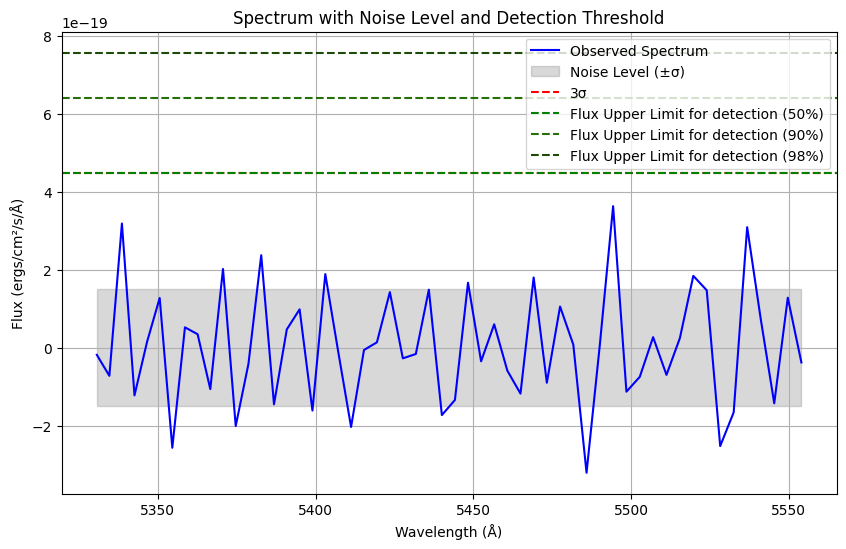

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(wavelengths, fluxes, label='Observed Spectrum', color='blue')
plt.fill_between(wavelengths, -sigma, sigma, color='gray', alpha=0.3, label='Noise Level (±σ)')
plt.axhline(y=detection_threshold * sigma, color='red', linestyle='--', label=f'{detection_threshold}σ')
plt.axhline(y=flux_upper_lim[0], color='green', linestyle='--', label='Flux Upper Limit for detection (50%)')
plt.axhline(y=flux_upper_lim[1], color='#267105', linestyle='--', label='Flux Upper Limit for detection (90%)')
plt.axhline(y=flux_upper_lim[2], color='#1c4a08', linestyle='--', label='Flux Upper Limit for detection (98%)')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux (ergs/cm²/s/Å)')
plt.title('Spectrum with Noise Level and Detection Threshold')
plt.legend()
plt.grid(True)
plt.savefig('nonfluxde.jpeg')
#plt.xlim(5230,5450)
plt.show()

100%|█████████████████████████████████████| 2064/2064 [00:00<00:00, 3916.90it/s]


enter region number: 7


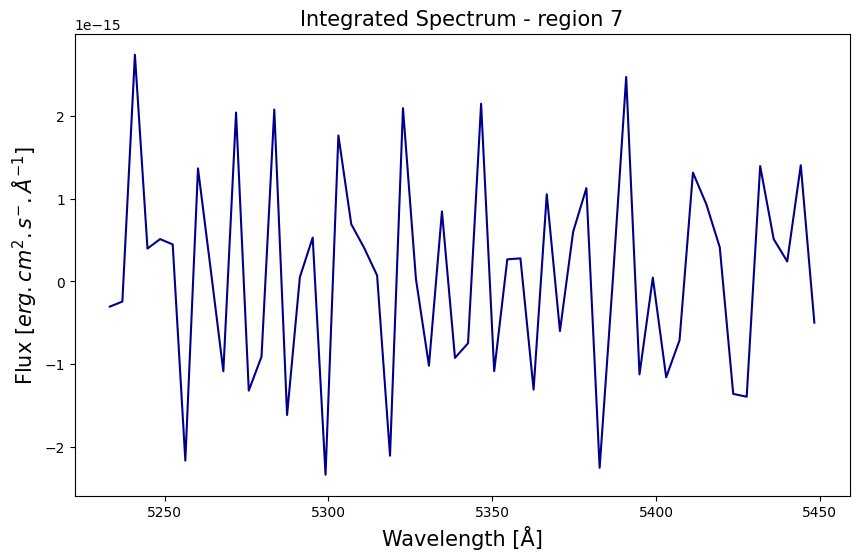

In [45]:
def read_ds9_region(region_file):
    regions = pyregion.open(region_file)
    return regions

# Function to extract region data from data cube
def extract_region_data(data_cube, regions, header):
    mask = regions.get_mask(hdu=fits.PrimaryHDU(header=header, data=data_cube[0]))
    return mask

# Function to integrate the spectrum
def integrate_spectrum(data_cube, mask, mean=False):
    integrated_spectrum = np.zeros(data_cube.shape[0])
    spec_ct = 0
    for i in tqdm(range(data_cube.shape[1])):
        for j in range(data_cube.shape[2]):
            if mask[i, j]:
                integrated_spectrum += data_cube[:, i, j]
                spec_ct += 1
    if mean:
        integrated_spectrum /= spec_ct
    return integrated_spectrum

def save_spectrum(wavelength_axis, integrated_spectrum_per_angstrom, filename):
    with open(filename, 'w') as f:
        f.write("# Wavelength (Å)  Flux (ergs/cm^2/s/Å)\n")
        for wavelength, flux in zip(wavelength_axis, integrated_spectrum_per_angstrom):
            f.write(f"{wavelength:.5f} {flux:.5e}\n")
def plot_spectrum(integrated_spectrum, header,figname):
    filter_cm1_min = header['HIERARCH filter_cm1_min']
    filter_cm1_max = header['HIERARCH filter_cm1_max']
    step_nb = header['STEP_NB']

    wavenumber_axis = np.linspace(filter_cm1_min, filter_cm1_max, step_nb)
    wavelength_axis = 1e8 / wavenumber_axis  # Convert cm^-1 to Angstroms

    # Calculate the wavelength step size
    wavelength_step = np.abs(np.diff(wavelength_axis)).mean()  # Mean step size in Ångstroms

    # Convert integrated spectrum to erg/cm^2/s/Å
    integrated_spectrum_per_angstrom = integrated_spectrum / wavelength_step
    save_spectrum(wavelength_axis, integrated_spectrum_per_angstrom, 'region_7_spec.txt')

    plt.figure(figsize=(10, 6))
    plt.plot(wavelength_axis[25:80], integrated_spectrum_per_angstrom, label='Integrated Spectrum',color='darkblue')
    plt.xlabel('Wavelength [Å]',size=15)
    plt.ylabel('Flux [$erg.cm^2.s^{-}.{\AA}^{-1}$]',size=15)
    title = 'Integrated Spectrum - region ' + input('enter region number: ')
    plt.title(title, size=15)
    #plt.legend()
    #plt.grid(True)
    plt.savefig(figname)
    plt.show()
    
# Example usage
figname = '/home/lucas/LUCI/Examples/crab_c3_field1/Results_paper/spectrum_region7_final.jpeg'
region_file = '../Luci_outputs/field_1_regions_paper/region7.reg'  # Replace with your DS9 region file
regions = read_ds9_region(region_file)

with fits.open('continuum_subtracted.fits') as hdul:
    data_cube = hdul[0].data
    header = hdul[0].header

mask = extract_region_data(data_cube, regions, header)
integrated_spectrum = integrate_spectrum(data_cube, mask)
plot_spectrum(integrated_spectrum, header,figname)

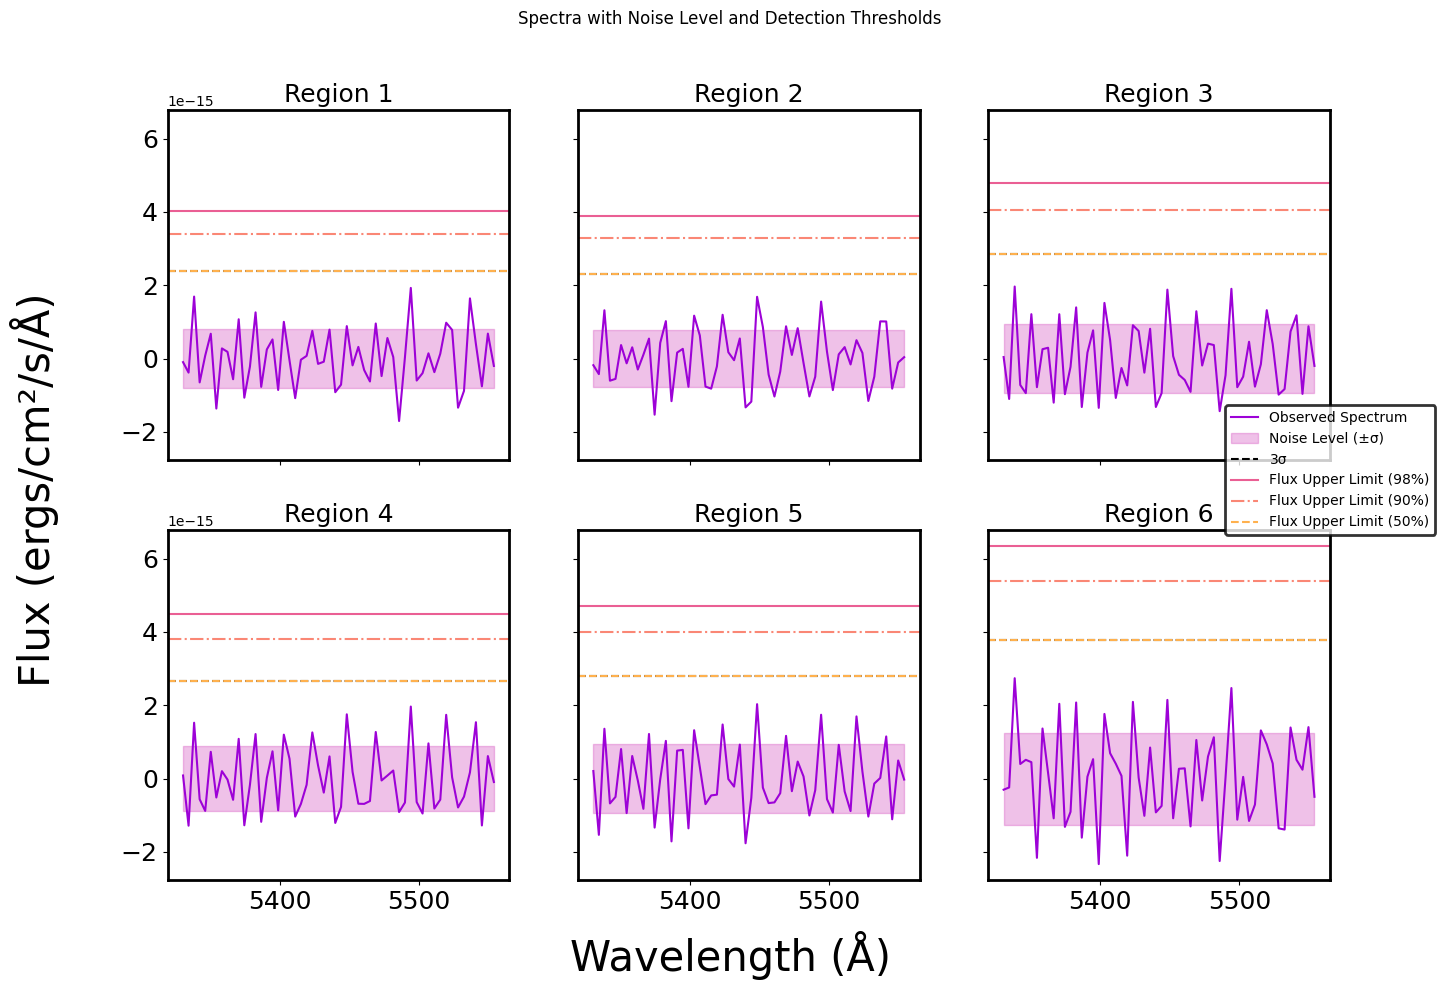

In [75]:
# Define a list of file paths for the spectra
spectra_files = ["region_1_spec.txt", "region_2_spec.txt","region_3_spec.txt","region_4_spec.txt","region_6_spec.txt", "region_7_spec.txt"]  # Add all 12 file paths

# Function to calculate the noise level (σ)
def calculate_noise_level(spectrum):
    """Calculate the standard deviation of the noise in the spectrum."""
    return np.std(spectrum)

# Function to calculate the flux upper limit for non-detection
def calculate_flux_upper_limit(sigma, detection_threshold, detection_probability):
    """Calculate the flux upper limit for non-detection."""
    inverse_erf_value = erfinv(2 * detection_probability - 1)
    flux_upper_limit = detection_threshold * sigma + np.sqrt(2) * sigma * inverse_erf_value
    return flux_upper_limit

# Set detection parameters
detection_threshold = 3  # 3σ detection threshold
desired_detection_probabilities = [0.50, 0.9, 0.98]  # Desired detection probabilities

# Set up the figure with shared x and y axes
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Spectra with Noise Level and Detection Thresholds')

# Loop through each file and plot each spectrum
for i, file_path in enumerate(spectra_files):
    data = np.loadtxt(file_path, skiprows=1)  # Load the spectrum data
    wavelengths = data[:, 0]
    fluxes = data[:, 1]
    
    # Calculate the noise level (σ)
    sigma = calculate_noise_level(fluxes)
    
    # Calculate flux upper limits for each desired probability
    flux_upper_limits = [calculate_flux_upper_limit(sigma, detection_threshold, prob)
                         for prob in desired_detection_probabilities]
    
    # Get the correct subplot location
    ax = axs[i // 3, i % 3]
    
    # Plot spectrum and detection thresholds
    ax.plot(wavelengths, fluxes, label='Observed Spectrum', color='#9d02d7')
    ax.fill_between(wavelengths, -sigma, sigma, color='#cd34b5', alpha=0.3, label='Noise Level (±σ)')
    ax.axhline(y=detection_threshold * sigma, color='black', linestyle='--', label=f'{detection_threshold}σ')
    ax.axhline(y=flux_upper_limits[2], color='#ea5f94', linestyle='-', label='Flux Upper Limit (98%)')
    ax.axhline(y=flux_upper_limits[1], color='#fa8775', linestyle='-.', label='Flux Upper Limit (90%)')
    ax.axhline(y=flux_upper_limits[0], color='#ffb14e', linestyle='--', label='Flux Upper Limit (50%)')
    
    
    # Set the title for each subplot
    ax.set_title(f'Region {i+1}',fontsize=18)
    #ax.grid(True)
    for spine in ax.spines.values():
        spine.set_linewidth(2)  # Set border thickness here

    # Increase tick label size
    ax.tick_params(axis='both', which='major', labelsize=18)  # Set tick size here

# Set labels only on the shared axes
fig.supxlabel('Wavelength (Å)',fontsize=30)
fig.supylabel('Flux (ergs/cm²/s/Å)',fontsize=30)

# Add legend to the first subplot only
handles, labels = axs[0, 0].get_legend_handles_labels()
legend = fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.83, 0.52), fontsize='medium', borderaxespad=0)
legend.get_frame().set_linewidth(2)
legend.get_frame().set_edgecolor("black")
# Save the figure
plt.savefig('spectra_flux_upper_limits.jpeg')
plt.show()
